# Robustness

**Table of contents**<a id='toc0_'></a>    
- 1. [Setup](#toc1_)    
- 2. [No IO](#toc2_)    
- 3. [General robustness checks](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ["NUMBA_PARFOR_MAX_TUPLE_SIZE"] = "200"

import numpy as np
import numba as nb
nb.set_num_threads(4)

import figs
from IHANKModel import HANKModelClass,HANKModelClass_RA

## 1. <a id='toc1_'></a>[Setup](#toc0_)

In [2]:
model_HANK = HANKModelClass(name='HANK')
model_HANK.load_data()
model_HANK.load_est_par(f'HANK_est_par_best',do_print=True)
model_HANK.load_x0s(f'HANK_x0s')

NKslope__T = 0.0745 [now: nan]
NKslope_NT = 0.0679 [now: nan]
NKWslope__T = 0.0493 [now: nan]
NKWslope_NT = 0.0005 [now: nan]
pi_index = 0.6595 [now: nan]
piW_index = 0.8136 [now: 0.0000]
phi = 1.3421 [now: nan]
phi_back = 0.1411 [now: nan]
phi_N = 1.7901 [now: nan]
phi_I = 5.5788 [now: nan]
kappa_r = 0.2890 [now: nan]
UIP_dev = 1.1098 [now: nan]
gamma = 2.9760 [now: nan]
phi_X = 0.7825 [now: nan]


In [3]:
model_RANK = HANKModelClass_RA(name='RANK',par={'HH_type':'RA-IM'})
model_RANK.load_data()
model_RANK.load_est_par(f'RANK_est_par_best')

## 2. <a id='toc2_'></a>[No IO](#toc0_)

In [4]:
models = {}
for model in [model_HANK,model_RANK]:

    print(f' {model.name}')

    model_ = model.copy()        
    model_.par.X_expshare *= 0.9 # reduce use of intermediate inputs by 10%
                                
    model_.find_ss()

    model_.compute_jacs(skip_shocks=True,skip_hh=len(model.outputs_hh)==0)
    model_.find_transition_path_foreign_shock()

    model_.compress_full()
    models[model.name] = model_


 HANK


 RANK


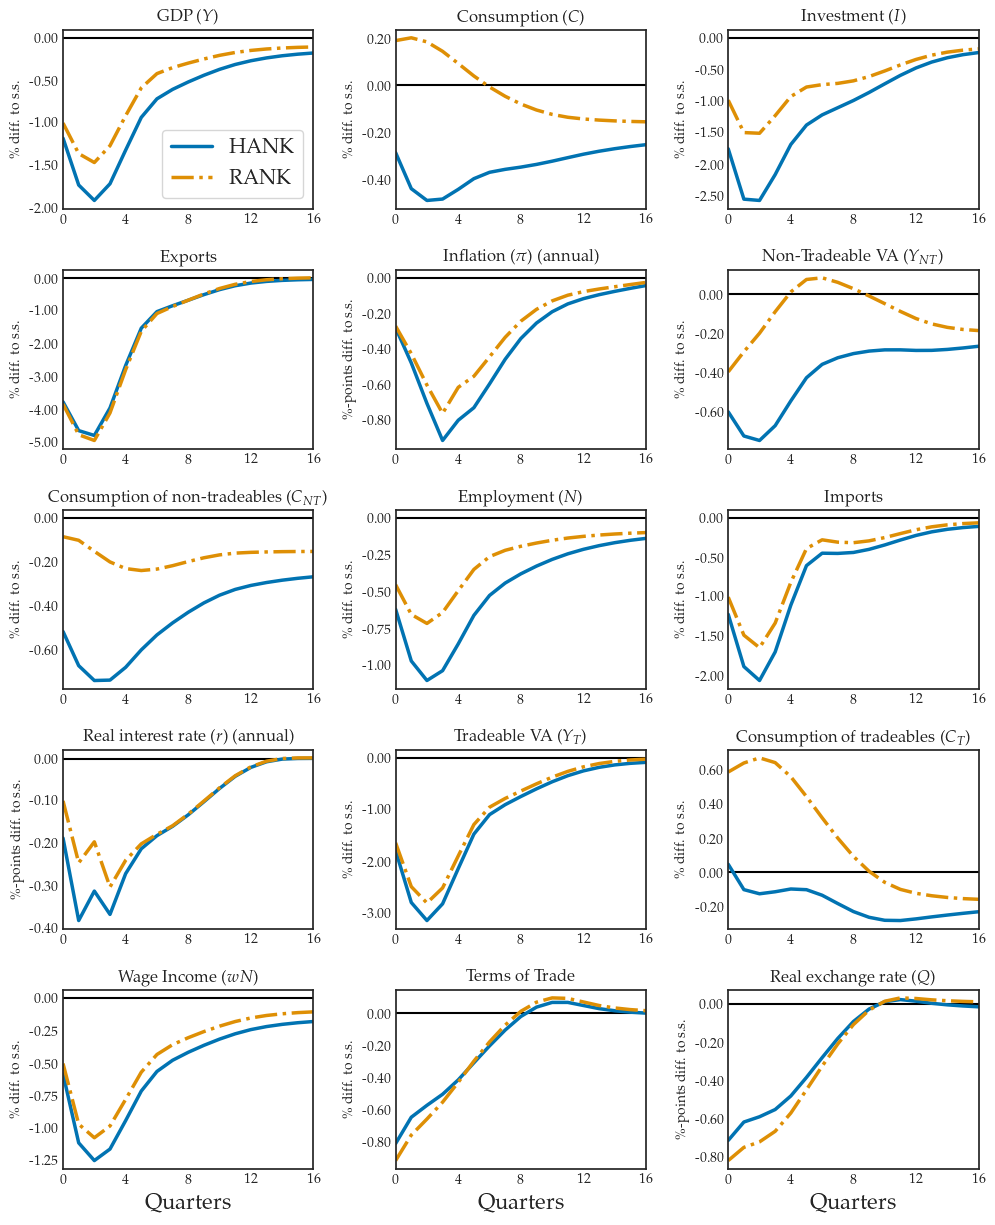

In [5]:
labels =  ['HANK', 'RANK']
lstyles = ['-', '-.']
lwidth = 2.5 
colors = ['C0','C1']

fig = figs.show_IRFs(models=models,paths='standard',labels=labels,
                        lwidth=lwidth,lstyles=lstyles,colors=colors,maxcol=3,figsize=[3.4,2.5])   

fig.savefig(fr'plots\responses_no_IO_floating.pdf')    

In [6]:
model_HANK.find_ss()


In [7]:
model_HANK.compute_jacs(skip_shocks=True)
model_HANK.find_transition_path_foreign_shock()

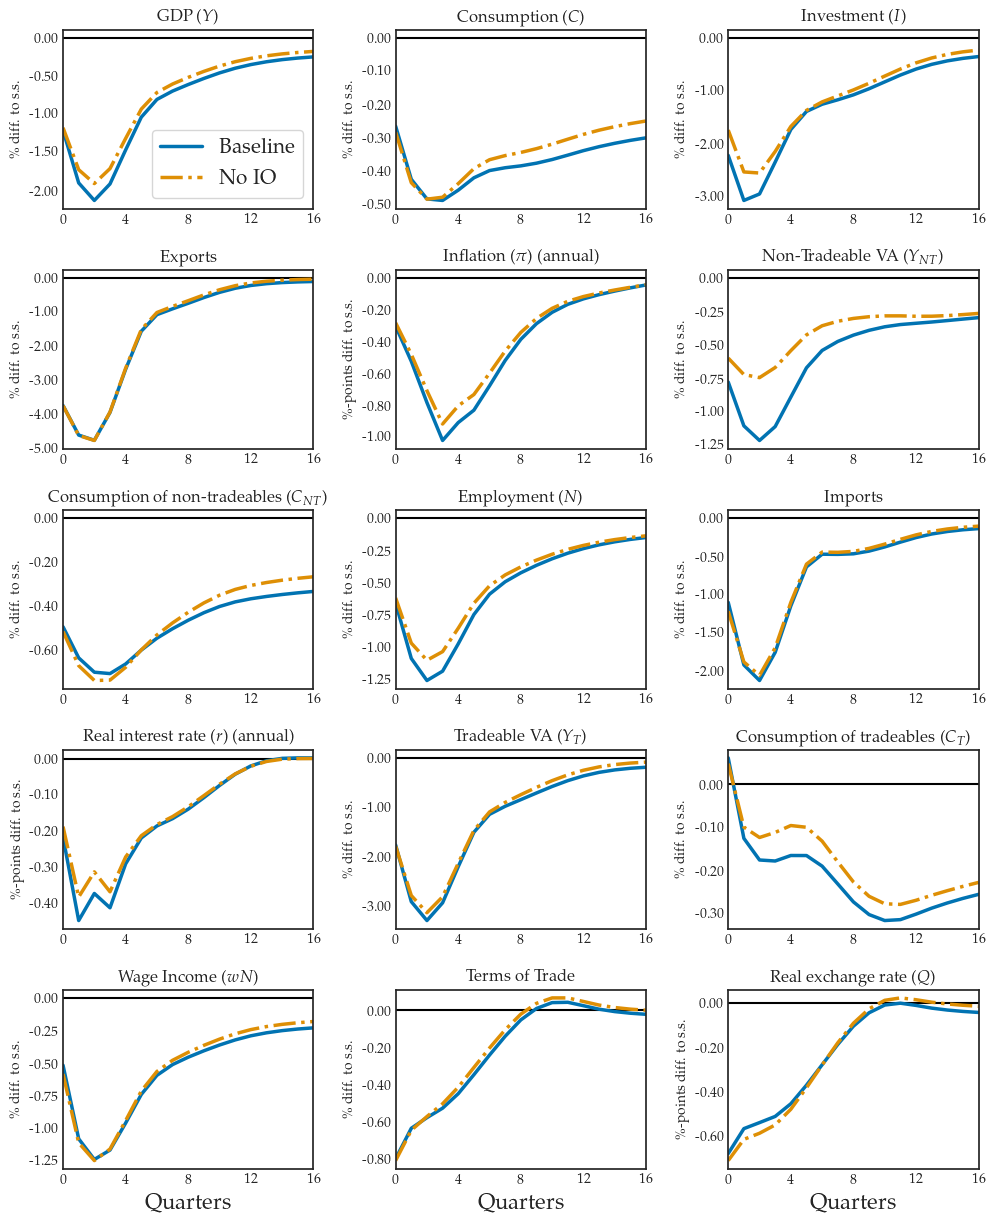

In [8]:
labels =  ['Baseline', 'No IO']
lstyles = ['-', '-.']
lwidth = 2.5 
colors = ['C0','C1']

fig = figs.show_IRFs(models=[model_HANK,models['HANK']],paths='standard',labels=labels,
                        lwidth=lwidth,lstyles=lstyles,colors=colors,maxcol=3,figsize=[3.4,2.5])   

fig.savefig(fr'plots\responses_no_IO_floating_HANK.pdf')    

## 3. <a id='toc3_'></a>[General robustness checks](#toc0_)

In [9]:
specs = {

    'Baseline':('Baseline',None),

    'gamma_low':(r'$\gamma = 0.1$',{'gamma':0.1}),
    'gamma_lhigh':(r'$\gamma = 4.0$',{'gamma':4.0}),

    'eta_low':(r'$\eta = 0.1$',{'eta':0.1}),
    'eta_high':(r'$\eta = 4.0$',{'eta':4.0}),

    'etaT':(r'$\eta^T =0.5$',{'etaT':0.5}),
    'CPI_Taylor':('CPI Taylor',{'TaylorType':'CPI'}),
    'Y Taylor':('Y taylor',{'TaylorType' :'Y'}), # not working
    
}

In [10]:
modelspecs = {}
for model in [model_HANK,model_RANK]:

    print(f'{model.name}')
    modelspecs[model.name] = {}

    for key,(sup_ylabel,par_dict) in specs.items():

        try:

            print(f' {sup_ylabel}: ',end='')

            if key == 'Baseline':
                model_ = model
            else:
                model_ = model.copy()
                for k,v in par_dict.items():
                    setattr(model_.par,k,v)

            model_.find_ss()
            model_.compute_jacs(skip_shocks=True,skip_hh=len(model.outputs_hh)==0)
            model_.find_transition_path_foreign_shock()

            if key != 'Baseline': model_.compress_full()

            modelspecs[model.name][key] = model_

            print('done')

        except Exception as e:
        
            print(e)

HANK
 Baseline: 

done
 $\gamma = 0.1$: 

done
 $\gamma = 4.0$: 

done
 $\eta = 0.1$: 

done
 $\eta = 4.0$: 

done
 $\eta^T =0.5$: 

done
 CPI Taylor: 

done
 Y taylor: 

done
RANK
 Baseline: 

done
 $\gamma = 0.1$: 

done
 $\gamma = 4.0$: 

done
 $\eta = 0.1$: 

done
 $\eta = 4.0$: 

done
 $\eta^T =0.5$: 

done
 CPI Taylor: 

done
 Y taylor: 

GEModelTools: No improvement for 5 iterations


In [11]:
modelspecs_ = {sup_ylabel:[modelspecs['HANK'][k],modelspecs['RANK'][k]] 
               for k,(sup_ylabel,par_dict) in specs.items() 
               if (k in modelspecs['HANK'] and k in modelspecs['RANK'])}

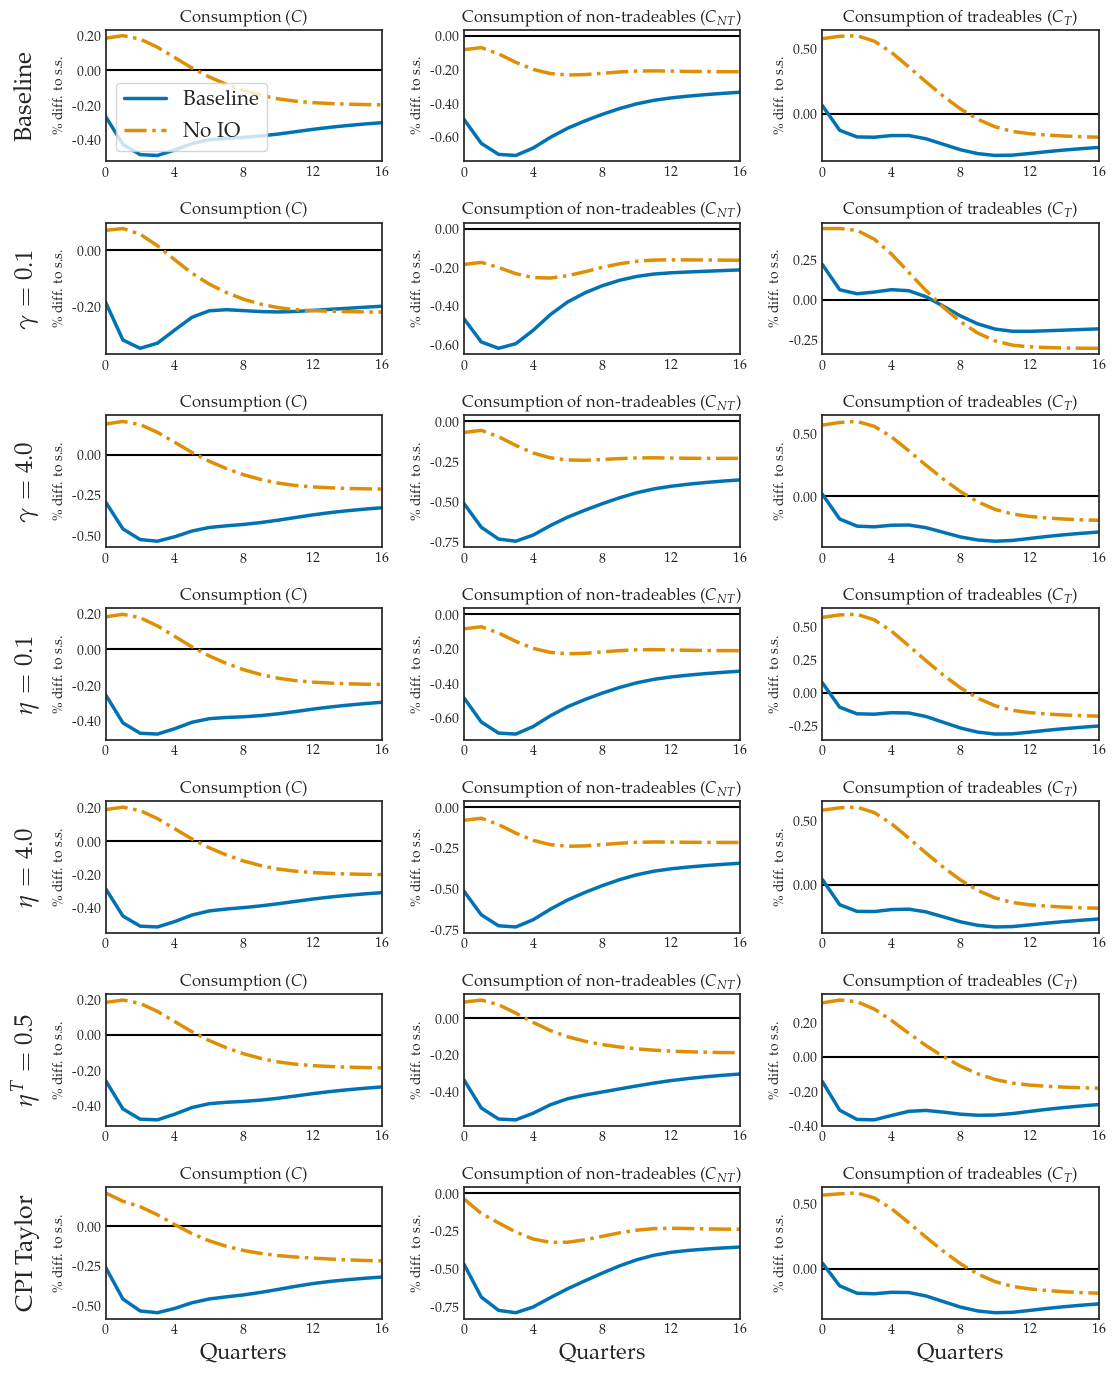

In [12]:
lwidth = 2.5 
lstyles = ['-', '-.']
colors = ['C0','C1']

paths = ['C','CNT', 'CT']

fig = figs.show_IRFs_robust(modelspecs_,paths,labels=labels,
              lwidth=lwidth,lstyles=lstyles,colors=colors,
              maxcol=3,figsize=[3.8,2])

fig.savefig(f'plots\model_robustness.pdf')